# Sprint（任意） Generative Adversarial Networks メンター用解答例

### メンター各位へ

以下の実装を参考にしているが、functional APIで揃えたり、メソッドを細かく作るなど分かりやすくするために書き換えている部分多い。そのまま載せた感は薄いはずである。

VanillaGAN

https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

ConditionalGAN

https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

### 動作するバージョン確認

Google Colab上で動作確認した。作成時、Kerasのバージョンは2.2.5。

In [0]:
import keras
print(keras.__version__)

2.2.5


### VanillaGAN解答例

問題1, 2, 3のコードを記述し完成させ、問題4の学習を行なっている。

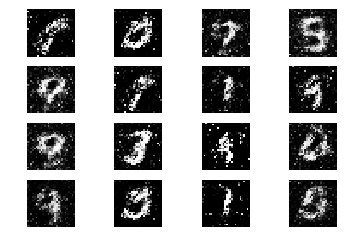

1990 step, [D loss: 0.612274] [G loss: 1.088036]


In [0]:
from keras.datasets import mnist
from keras.layers import BatchNormalization, Dense, Flatten, Input, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from IPython import display
import matplotlib.pyplot as plt
import numpy as np

import os

class VanillaGAN():
    """
    VanillaGAN

    Goodfellow, I. J., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., and Bengio, Y. (2014). Generative adversarial nets. In NIPS’2014. https://arxiv.org/pdf/1406.2661.pdf

    Parameters
    ----------------
    img_shape : tuple of int
        生成する画像の形。順番は（縦, 幅, チャンネル数）。(default : (28, 28, 1))
    noise_dim : int
        ノイズの次元数 (default : 100)
    """
    def __init__(self, img_shape=(28, 28, 1), noise_dim=100):
        self.img_shape = img_shape
        self.noise_dim = noise_dim
        self.optimizer = Adam(lr=0.0002, beta_1=0.5)
        self.compile_models()

    def compile_models(self):
        """
        Modelインスタンスのコンパイルを行う
        """
        self.discriminator = self.discriminator_model()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'])
        
        self.adversarial = self.adversarial_model()
        self.adversarial.compile(loss='binary_crossentropy', optimizer=self.optimizer)
  
    def generator_model(self):
        """
        GeneratorのModelインスタンスを作る
        """
        noise = Input(shape=(self.noise_dim,))
        x = Dense(128, input_dim=self.noise_dim)(noise)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(1024)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(np.prod(self.img_shape), activation='tanh')(x)
        gen_img = Reshape(self.img_shape)(x)
        return Model(inputs=noise, outputs=gen_img)

    def discriminator_model(self):
        """
        DiscriminatorのModelインスタンスを作る
        """
        img = Input(shape=self.img_shape)
        x = Flatten(input_shape=self.img_shape)(img)
        # 問題2で作成
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        validity = Dense(1, activation='sigmoid')(x)
        return Model(inputs=img, outputs=validity)

    def adversarial_model(self):
        """
        DiscriminatorとGeneratorを繋げたModelインスタンスを作る
        """
        self.generator = self.generator_model()
        self.discriminator.trainable = False

        noise = Input(shape=(self.noise_dim,))
        # 問題3で作成
        gen_img = self.generator(noise)
        validity = self.discriminator(gen_img)
        return Model(inputs=noise, outputs=validity)

    def create_noise(self, batch_size):
        """
        Parameters
        ----------------
        batch_size : int
            ミニバッチのサイズ

        Returns
        ----------------
        noise : ndarray, shape(batch_size, noise_dim)
            ノイズ（ミニバッチのサイズ×潜在変数の次元数）
        """
        # 問題1で作成
        noise = np.random.normal(0, 1, (batch_size, self.noise_dim))
        return noise

    def train(self, n_steps, batch_size=128, sample_interval=100):
        """
        VanillaGANを学習する

        Parameters
        ----------------
        n_steps : int
            学習するステップ数   
        batch_size : int
            バッチサイズ (default : 128)
        sample_interval : int
            サンプル画像を生成して表示・保存するステップの間隔 (default : 100)
        """
        os.makedirs("gen_imgs", exist_ok=True)
        (X_train, y_train), (_, _) = mnist.load_data()

        n_iters = np.ceil(X_train.shape[0]/batch_size).astype(np.int)

        X_train = X_train/127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        real_label = np.ones((batch_size, 1))
        fake_label = np.zeros((batch_size, 1))

        for step in range(n_steps):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_imgs = X_train[idx]

            noise = self.create_noise(batch_size)

            # train the discriminator
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(real_imgs, real_label)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake_label)
            d_loss = (d_loss_real[0] + d_loss_fake[0])/2
            
            # train the generator
            g_loss = self.adversarial.train_on_batch(noise, real_label)

            if step % sample_interval == 0:
                self.show_sample_images(step)
                print ("%d step, [D loss: %f] [G loss: %f]" % (step, d_loss, g_loss))

    def show_sample_images(self, step):
        """
        サンプル画像を生成して表示・保存する

        Parameters:
        ----------------
        step : int
            ステップの番号
        """
        n_sample_rows, n_sample_cols = (4, 4)
        noise = self.create_noise(n_sample_rows*n_sample_cols)
        gen_imgs = self.generator.predict(noise)
        gen_imgs = gen_imgs/2 + 0.5

        fig, axs = plt.subplots(n_sample_rows, n_sample_cols)
        count = 0
        for row in range(n_sample_rows):
            for col in range(n_sample_cols):
                axs[row, col].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                axs[row, col].axis('off')
                count += 1
        display.clear_output(wait=True)
        display.display(plt.gcf())
        fig.savefig("gen_imgs/%d.png" % (step))
        plt.close()

vanilla_gan = VanillaGAN()
vanilla_gan.train(n_steps=2000, batch_size=128)

## 疑問への答え

### なぜlr=0.0002, beta_1=0.5？

DCGANがAdamを使い、その時これが良いとされた。lrは低いところからはじめる。他にもいろいろと研究されているが、ここではそれを採用した。Batch normalizationの導入もDCGAN。

### ConditionalGAN解答例

### 問題5

追加する要素

- ラベルの情報をGeneratorとDiscriminatorに入力する。

### 問題6

以下のコードではVanillaGANからの追加や変更を行なった行にその旨をコメントしている。


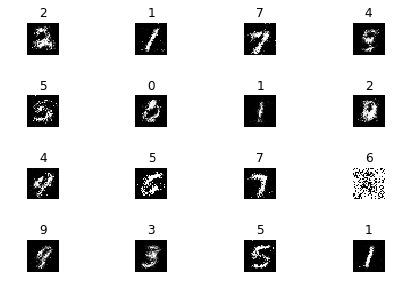

1900 step, [D loss: 0.640937] [G loss: 1.004577]


In [28]:
from keras.datasets import mnist
from keras.layers import BatchNormalization, Dense, Embedding, Flatten, Input, multiply, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from IPython import display
import matplotlib.pyplot as plt
import numpy as np

import os

class ConditionalGAN(): # 変更
    """
    ConditionalGAN

    Mirza, Mehdi and Osindero, Simon, Conditional generative adversarial nets, arXiv preprint arXiv:1411.1784, 2014. https://arxiv.org/pdf/1411.1784.pdf

    Parameters
    ----------------
    img_shape : tuple of int
        生成する画像の形。順番は（縦, 幅, チャンネル数）。(default : (28, 28, 1))
    n_classes : int
        生成する画像のクラス数 (defalut : 100)
    noise_dim : int
        ノイズの次元数 (default : 100)
    """
    def __init__(self, img_shape=(28, 28, 1), n_classes=10, noise_dim=100): # 変更
        self.img_shape = img_shape
        self.n_classes = n_classes # 追加
        self.noise_dim = noise_dim
        self.optimizer = Adam(lr=0.0002, beta_1=0.5)
        self.compile_models()

    def compile_models(self):
        """
        Modelインスタンスのコンパイルを行う
        """
        self.discriminator = self.discriminator_model()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'])
        
        self.adversarial = self.adversarial_model()
        self.adversarial.compile(loss='binary_crossentropy', optimizer=self.optimizer)
  
    def generator_model(self):
        """
        GeneratorのModelインスタンスを作る
        """
        noise = Input(shape=(self.noise_dim,))
        label = Input(shape=(1,), dtype='int32') # 追加
        label_embedding = Flatten()(Embedding(self.n_classes, self.noise_dim)(label)) # 追加
        x = multiply([noise, label_embedding]) # 追加
        x = Dense(128, input_dim=self.noise_dim)(x) # 変更
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(1024)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(np.prod(self.img_shape), activation='tanh')(x)
        gen_img = Reshape(self.img_shape)(x)
        return Model(inputs=[noise, label], outputs=gen_img) # 変更

    def discriminator_model(self):
        """
        DiscriminatorのModelインスタンスを作る
        """
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32') # 追加
        label_embedding = Flatten()(Embedding(self.n_classes, np.prod(self.img_shape))(label)) # 追加
        x = Flatten(input_shape=self.img_shape)(img)
        x = multiply([x, label_embedding]) # 追加
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        validity = Dense(1, activation='sigmoid')(x)
        return Model(inputs=[img, label], outputs=validity) # 変更

    def adversarial_model(self):
        """
        DiscriminatorとGeneratorを繋げたModelインスタンスを作る
        """
        self.generator = self.generator_model()
        self.discriminator.trainable = False

        noise = Input(shape=(self.noise_dim,))
        label = Input(shape=(1,), dtype='int32') # 追加
        gen_img = self.generator([noise, label]) # 変更
        validity = self.discriminator([gen_img, label]) # 変更
        return Model(inputs=[noise, label], outputs=validity) # 変更

    def create_noise(self, batch_size):
        """
        Parameters
        ----------------
        batch_size : int
            ミニバッチのサイズ

        Returns
        ----------------
        noise : ndarray, shape(batch_size, noise_dim)
            ノイズ（ミニバッチのサイズ×潜在変数の次元数）
        """
        noise = np.random.normal(0, 1, (batch_size, self.noise_dim))
        return noise

    def train(self, n_steps, batch_size=128, sample_interval=100):
        """
        ConditionalGANを学習する

        Parameters
        ----------------
        n_steps : int
            学習するステップ数   
        batch_size : int
            バッチサイズ (default : 128)
        sample_interval : int
            サンプル画像を生成して表示・保存するステップの間隔 (default : 100)
        """
        os.makedirs("gen_imgs", exist_ok=True)
        (X_train, y_train), (_, _) = mnist.load_data()

        n_iters = np.ceil(X_train.shape[0]/batch_size).astype(np.int)

        X_train = X_train/127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        real_label = np.ones((batch_size, 1))
        fake_label = np.zeros((batch_size, 1))

        for step in range(n_steps):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_imgs = X_train[idx]
            labels = y_train[idx] # 追加

            noise = self.create_noise(batch_size)

            # train the discriminator
            gen_imgs = self.generator.predict([noise, labels]) # 変更

            d_loss_real = self.discriminator.train_on_batch([real_imgs, labels], real_label) # 変更
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake_label) # 変更
            d_loss = (d_loss_real[0] + d_loss_fake[0])/2
            
            # train the generator
            sampled_labels = np.random.randint(0, self.n_classes, batch_size).reshape(-1, 1) # 追加
            g_loss = self.adversarial.train_on_batch([noise, sampled_labels], real_label) # 修正

            if step % sample_interval == 0:
                self.show_sample_images(step)
                print ("%d step, [D loss: %f] [G loss: %f]" % (step, d_loss, g_loss))

    def show_sample_images(self, step):
        """
        サンプル画像を生成して表示・保存する

        Parameters:
        ----------------
        step : int
            ステップの番号
        """
        n_sample_rows, n_sample_cols = (4, 4)
        noise = self.create_noise(n_sample_rows*n_sample_cols)
        sampled_labels = np.random.randint(0, self.n_classes, n_sample_rows*n_sample_cols).reshape(-1, 1) # 追加
        gen_imgs = self.generator.predict([noise, sampled_labels]) # 変更
        gen_imgs = gen_imgs/2 + 0.5

        fig, axs = plt.subplots(n_sample_rows, n_sample_cols, constrained_layout=True) # 変更
        count = 0
        for row in range(n_sample_rows):
            for col in range(n_sample_cols):
                axs[row, col].set_title("%d" % (sampled_labels[count]))
                axs[row, col].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                axs[row, col].axis('off')
                count += 1
        display.clear_output(wait=True)
        display.display(plt.gcf())
        fig.savefig("gen_imgs/cgan_%d.png" % (step)) # 変更（ファイル名区別）
        plt.close()

conditional_gan = ConditionalGAN() # 変更
conditional_gan.train(n_steps=2000, batch_size=128) # 変更